# CMD models for JWST

The goal with this notebook is to create a model for the Color Magnitude Diagram of JWST Nircam filters F200W, F300M, F335M, F360M. For the testing part, I am using the MakeCMD function from the XRBID package and I will try to update that function to incorporate JWST.

In [1]:
import re
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as img
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from scipy.interpolate import interp1d
from astropy.io.votable import parse
from numpy import nanmedian, nanstd, nanmean, median, std, mean, log10
import pandas as pd
import os
from XRBID.DataFrameMod import Find, BuildFrame
from XRBID.Sources import LoadSources, GetDaoPhots

cd = os.chdir
pwd = os.getcwd
pd.options.mode.chained_assignment = None

cd('/Users/undergradstudent/Research/XRB-Analysis/jwst-models')

**Notes**
1. The models for the colour magnitude diagram were found from the Padova models [website](https://stev.oapd.inaf.it/cgi-bin/cmd). The step size 0.009 was used for the query of the data. 
2. For creating smooth color-magnitude diagrams, x values have been sorted in ascending order, meanwhile y values have been sorted in a descending order. 
3. The $20M_{\odot}$ dataFrame contains data of $19.9 \geq$ Mass since the evolutionary track does not slouch forward. 
4. The models have been succesfully incorporated into [XRBID.CMDs.MakeCMD](https://github.com/QosmicQi/XRBID/blob/main/XRBID/CMDs.py).

# Testing with color magnitude diagrams

## Functions

In [26]:
def MakeCMD(sources=False, xcolor=None, ycolor=None, xmodel=None, ymodel=None, figsize=(6,4), xlim=None, ylim=None, color="black", size=10, marker=None, label=None, save=False, savefile=None, title=None, subimg=None, annotation=None, annotation_size=None, imshow=True, fontsize=15, shift_labels=[[0,0],[0,0],[0,0],[0,0],[0,0]], set_labels=None, instrument="ACS", color_correction=[0,0], labelpoints=False, file_dir=False): 

	"""Makes a CMD from a given set of points, either from a list or an input dataframe.

	PARAMETERS: 
	sources 	[pd.dataframe, list]: 	Input may either be a pandas dataframe containing the appropriate magnitudes required for the CMD, 
				       		or a list of coordinates in the format [[xs],[ys]]. 
	xcolor 		[str or list]: 		The name of the color or magnitude to plot in the x-axis, as it is labeled in the dataframe. 
						This will be the default x-axis label. If a list is given, it is assumed to contain the 
						column names of the input dataframe to be subtracted (e.g. F555W - F814W)
	ycolor 		[str or list]: 		The name of the color or magnitude to plot in the y-axis, as it is labeled in the dataframe. 
						This will be the default y-axis label. If a list is given, it is assumed to contain the column 
						names of the input dataframe to be subtracted (e.g. F555W - F814W)
	xmodel 		[str or list]: 		The magnitude(s) of the filter(s) to be used from the stellar models for the x-axis. 
						If given as a list, it is assumed the color is xmodel[0] - xmodel[1] 
	ymodel 		[str or list]: 		The magnitude(s) of the filter(s) to be used from the stellar models for the y-axis. 
						If given as a list, it is assumed the color is ymodel[0] - ymodel[1] 
	figsize 	[tuple] (6,4): 		The desired dimensions of the figure. 
	xlim 		[tuple] (None):		The limits on the x-axis. If none are given, the limits are assumed to be the (xmin - 1, xmax + 1) 
	ylim 		[tuple] (None):		The limits on the y-axis. If none are given, the limits are assumed to be (ymax + 1, ymin - 1)
	color 		[str] ("black"): 	Marker color
	size 		[int] (10): 		Marker size
	marker 		[str] (None):		The style of the marker. Defaults to a filled point. If "o" is given, 
						the marker is set to be an open circle. 
	label 		[str] (None):		The legend label to assign to the input points from sources. 
	save 		[bool] (False): 	Sets whether to automatically same the CMD image. 
	savefile 	[str] (None): 		The name to assigned the saved CMD image. 
	title 		[str] (None): 		Title of the figure.
	subimg 		[str] (None): 		Filename of an image to include in the corner of the CMD. 
						This is to allow a subplot of the XRB plotted to be shown within the CMD. 
	annotation 	[str] (None): 		Additional annotation to add to the bottom corner of the CMD (usually XRB ID)
	annotation_size [int] (None): 		Annotation fontsize 
	imshow 		[bool] (True): 		Shows the plot.
	fontsize 	[int] (20): 		The fontsize of text other than the annoations
	shift_labels 	[list]: 		List of x and y coordinate distances by which to shift each of the model mass labels.
						Defaults to [[0,0],[0,0],[0,0],[0,0],[0,0]] (no shifts)
	set_labels 	[list] (None):		Sets the position of labels. If none is given, positions are automatically calculated.
	instrument 	[str] ("ACS"): 		Name of the instrument used, to determine which models to call. 
	color_correction [list] ([0,0]):	Corrections on the x and y position of the sources. Defaults to no correction. 
	labelpoints 	[list] (False): 	Labels to add to each point. If none are given, defaults to False and no labels added. 
	file_dir 	[str]: 			The directory within which the models may be found. By default, the 
						code attempts to find this automatically, but if it fails, it will 
						prompt the user to input the directory manually. 

	RETURNS: 
	f, ax: 		Arguments defining the figure, which can be used to add more points to the CMD after the initial plotting.
 
	"""

	# Setting the style of my plots
	#fontparams = {'font.family':'stix'}
	#labelparams = {'family':'stix', 'size':fontsize}
	
	curr_dir = pwd()

	# If no file directory is given, assume the files we need are in the same directory
	# where the module is saved
	#if not file_dir: 
	#	file_dir = os.path.dirname(os.path.abspath(__file__))

	#try: cd(file_dir)
	#except: print("Directory containg CMD models not found.\nPlease check and input the correct directory manually with file_dir.")

	# Reading in the appropriate models based on the instrument given.
	#if instrument.upper() =="WFC3":
	#	mass1 = pd.read_csv("isoWFC3_1Msun.frame")
	#	mass3 = pd.read_csv("isoWFC3_3Msun.frame")
	#	mass5 = pd.read_csv("isoWFC3_5Msun.frame")
	#	mass8 = pd.read_csv("isoWFC3_8Msun.frame")
	#	mass20 = pd.read_csv("isoWFC3_20Msun.frame")
	#elif instrument.upper() =="ACS": 
	#	mass1 = pd.read_csv("isoACS_WFC_1Msun.frame")
	#	mass3 = pd.read_csv("isoACS_WFC_3Msun.frame")
	#	mass5 = pd.read_csv("isoACS_WFC_5Msun.frame")
	#	mass8 = pd.read_csv("isoACS_WFC_8Msun.frame")
	#	mass20 = pd.read_csv("isoACS_WFC_20Msun.frame")

	if instrument.upper() =="WFC3": masses = wfc3_masses # list of DataFrames of each mass model
	elif instrument.upper() == 'ACS': masses = acs_masses
	else: masses = [onesolarmass,
					threesolarmass, 
					fivesolarmass,
					eightsolarmass,
					twentysolarmass]

	mass_labels = [r"1 M$_\odot$", r"3 M$_\odot$", r"5 M$_\odot$", r"8 M$_\odot$", r"20 M$_\odot$"]

	#cd(curr_dir) 

	if savefile: save = True

	# Setting the x- and y-axes labels.
	# if xcolor and/or ycolor is a list, will need to set color[0] - color[1] as the color of the appropriate axis
	if not xcolor: xcolor=xmodel
	if not ycolor: ycolor=ymodel

	if isinstance(xcolor, list): xlabel = " - ".join(xcolor)
	else: xlabel = xcolor
	if isinstance(ycolor, list): ylabel = " - ".join(ycolor)
	else: ylabel = ycolor

	### Pulling the x and y values of the sources ###
	# if input source is a pandas dataframe, read in the appropriate colors and magnitudes (and add correction, if needed)
	if isinstance(sources, pd.DataFrame):
		if isinstance(xcolor, list): xsources = sources[xcolor[0]].values - sources[xcolor[1]].values + color_correction[0]
		else: xsources = sources[xcolor].values + color_correction[0]
		if isinstance(ycolor, list): ysources = sources[ycolor[0]].values - sources[ycolor[1]].values + color_correction[1]
		else: ysources = sources[ycolor].values + color_correction[1]
		
	elif sources: # If sources is a list or coordinates, pull the x and y values as given (with additional color correction)
		xsources = (np.array(sources[0]) + color_correction[0]).tolist()
		ysources = (np.array(sources[1]) + color_correction[1]).tolist()	
	### Will only need to call xsources or ysources from now on ###

	
	### PLOTTING MODEL MASS TRACKS ###

	f, ax = plt.subplots(figsize=figsize)

	# Setting the tick parameters
	ax.tick_params(direction="in", labelsize=15, bottom=True, \
		       top=True, left=True, right=True, length=7, width=2)
	ax.grid(alpha=0.8, linestyle="--")

	# If no xmodel or ymodel are given, default to that of the sources. 
	# This point will fail if the filters of the sources are not given a name corresponding to the filters in the model DataFrame!
	if not xmodel: xmodel=xcolor
	if not ymodel: ymodel=ycolor

	# Pulling the correct colors/magnitudes from the models and plotting
	# and setting the default mass track label position and plot limits
	xlims = []
	ylims = []
	for m, mass in enumerate(masses): # for each of the mass models, pull the color/mag given by xmodel and ymodel
		if isinstance(xmodel, list): 
			xtemp = mass[xmodel[0]].values - mass[xmodel[1]].values
			xtemp_label = max(xtemp) + 0.1 + shift_labels[m][0] # default mass label position, unless set_labels is given
			xtemp_left = max(xtemp)	# Keeping track of the leftmost x coordinate		
			if not xlim: xlims.append([min(xtemp)-1, max(xtemp)+1])
			invert_xlim = False
		else: # if x-axis is a magnitude..
			xtemp = mass[xmodel].values
			xtemp_label = min(xtemp) - 0.1 + shift_labels[m][0]
			xtemp_left = min(xtemp)
			if not xlim: xlims.append([max(xtemp)+1, min(xtemp)-1])
			invert_xlim = True
		if isinstance(ymodel, list): 
			ytemp = mass[ymodel[0]].values - mass[ymodel[1]].values
			if not ylim: ylims.append([min(ytemp)-1, max(ytemp)+1])
			invert_ylim = False
		else: # of y-axis is a magnitude...
			ytemp = mass[ymodel].values
			if not ylim: ylims.append([max(ytemp)+1, min(ytemp)-1])
			invert_ylim = True

		# Finding the best y-coordinate for the model label based on the leftmost
		ytemp_label = ytemp[xtemp.tolist().index(xtemp_left)] + invert_ylim*0.5 + shift_labels[m][1]

		# If set_labels is given, use this as the coordinate of the label
		# (overrides the label positions set above)
		if set_labels: 
			xtemp_label = set_labels[m][0]
			ytemp_label = set_labels[m][1]

		# Plotting mass track and mass label
		plt.plot(xtemp, ytemp, color="black", lw=1)
		ax.annotate(mass_labels[m], xy=(xtemp_label, ytemp_label), size=15)

	xlims = np.array(xlims)
	ylims = np.array(ylims) 

	# PLOTTING SOURCE POINTS
	if isinstance(sources, pd.DataFrame) or isinstance(sources, list): 
		if marker == "o": 	# 'o' used for open circle 
			ax.scatter(xsources, ysources, facecolor="none", edgecolor=color, s=size, label=label)
		elif marker == None: 	# default is a closed circle 
			ax.scatter(xsources, ysources, color=color, s=size, label=label)
		else: 
			ax.scatter(xsources, ysources, color=color, s=size, label=label, marker=marker)

		# PLOTTING POINT NAMES, IF GIVEN
		if labelpoints: 
			for i in range(len(labelpoints)): 
				ax.annotate(labelpoints[i], xy=[xsources[i], ysources[i]-.2], size=10, horizontalalignment="center")

	# Setting plot limits
	if not xlim:
		if invert_xlim: plt.xlim(max(xlims.T[0]), min(xlims.T[1]))
		else: plt.xlim(min(xlims.T[0]), max(xlims.T[1]))
	else: plt.xlim(xlim)
	if not ylim: 
		if invert_ylim: plt.ylim(max(ylims.T[0]), min(ylims.T[1]))
		else: plt.ylim(min(ylims.T[0]), max(ylims.T[1]))
	else: plt.ylim(ylim)

	# plotting mass track labels
	plt.xlabel(xlabel, labelpad=0, fontsize=fontsize)#, labelparams, labelpad=0)
	plt.ylabel(ylabel, labelpad=-10, fontsize=fontsize)#, labelparams, labelpad=-10)


	# If another title (such as name of the object) is given, plot
	# Adjusts size to make it fit the size of the plot
	if 0.6*figsize[0]*figsize[1] > 30: titlesize = 30
	else: titlesize = 0.6*figsize[0]*figsize[1]

	if not annotation_size: annotation_size = titlesize

	if title: ax.set_title(title, fontsize=titlesize)

	# If an annotation is given, add it to the bottom of the figure
	if annotation: ax.annotate(annotation, xy=(xlim[1]-0.05*abs(xlim[1]), ylim[0]-0.1*abs(ylim[1])), size=annotation_size, horizontalalignment="right")

	# if a subimage is given as a filename, read in. 
	if subimg and "." in subimg: 
		subimg = img.imread(subimg)

	# If an image is passed to overlay on plot, add 
	if hasattr(subimg, 'shape'): # tests if subimg was fed in
		try: 
			XY = [figsize[0], figsize[1]]
			ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
			ax2.imshow(subimg)
			ax2.axis('off')
		except: 
			im = plt.imread(subimg)
			XY = [figsize[0], figsize[1]]
			ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
			ax2.imshow(im)
			ax2.axis('off')

	# saving image, if prompted
	if savefile != None: save = True; pass;
	if save:
		if savefile == None: 
			savefile = df["ID"][0].split("X")[0] + "_" + xcolors + "_" + ycolors
		plt.savefig(savefile.split(".")[0]+".jpg", dpi=300, bbox_inches="tight")

	# Returning plot information, in case I need this later
	# need to retrieve ax if using both subimg followed by AddCMD

	cd(curr_dir)
	return f, ax

In [178]:
def plot_isochrone(df : pd.core.frame.DataFrame,
                   xmodel: list, 
                   ymodel: str, 
                   label: int = 5,
                   cmap=plt.cm.jet, 
                   colormap_param: str ='logAge',
                   xlim: tuple = (-2, 10),
                   ylim: tuple = (4, -14),
                   save: bool = False):
    '''A function to plot the evolutionary track isochrone.'''

    # sort the x values in an ascending order to get the smooth shape of the isocrhone
    x = np.sort(np.array(df[xmodel[0]].values - df[xmodel[1]].values))
    # sort the y values in a descending order to get the smooth shape of the isocrhone
    y = np.sort(np.array(df[ymodel].values))
    y = y[::-1]
    # z will be used for the scaling of the colormap
    z = df[colormap_param]
    fig, ax = plt.subplots()
    cmap = cmap
    norm = plt.Normalize(z.min(), z.max())
    for i in range(len(x)-1):
        ax.plot(x[i:i+2], y[i:i+2], color=cmap(norm(z[i])))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=ax)

    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(y.max(), y.min())

    ax.set_xlabel(f'{xmodel[0]} - {xmodel[1]}')
    ax.set_ylabel(ymodel)
    ax.annotate(f'{label}'+r'$M_{\odot}$', xy=[max(x), min(y)+0.5], size=15)
    
    if save:
        plt.savefig(f'{label}M_isochrone.png')

In [ ]:
def plot_jwst_cmd(masses: list,
                  sources=None,
                  xcolor=None,
                  ycolor=None,
                  xmodel: list = ['F200W', 'F335M'],
                  ymodel: str = 'F360M',
                  xlim: tuple = (-2, 10),
                  ylim: tuple = (2, -14),
                  cmap = plt.cm.jet,
                  save: bool = False):
    '''A function to plot the colour magnitude diagram for JWST NIRCam.
    
    NOTE
    ----
    Do not trust the colormap that is being generated by this function.'''
    z = isodata['logAge'] # for the scaling of the colormap
    mass_labels = [r"1M$_\odot$",
                   r"3M$_\odot$",
                   r"5M$_\odot$",
                   r"8M$_\odot$",
                   r"20M$_\odot$"]

    fig, axs = plt.subplots()
    z = isodata['logAge']
    norm = plt.Normalize(z.min(), z.max())

    for m, mass in enumerate(masses):
        df = mass.copy()
        x = np.sort(np.array(df[xmodel[0]].values - df[xmodel[1]].values))
            # sort the y values in a descending order to get the smooth shape of the isocrhone
        y = np.sort(np.array(df[ymodel].values))
        y = y[::-1]
        for i in range(len(x)-1):
            axs.plot(x[i:i+2], y[i:i+2], color=cmap(norm(z[i])))
        axs.annotate(mass_labels[m], xy=[max(x)+0.2, min(y)+0.2], size=15)

    axs.set_xlim(xlim[0], xlim[1])
    axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(f'{xmodel[0]} - {xmodel[1]}')
    axs.set_ylabel(ymodel)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=axs)

    if isinstance(sources, pd.DataFrame):
        if isinstance(xcolor, list): xsources = sources[xcolor[0]].values - sources[xcolor[1]].values 
        else: xsources = sources[xcolor].values + color_correction[0]
        if isinstance(ycolor, list): ysources = sources[ycolor[0]].values - sources[ycolor[1]].values 
        else: ysources = sources[ycolor].values + color_correction[1]
    if isinstance(sources, pd.DataFrame):
        if marker == "o":     # 'o' used for open circle 
            axs.scatter(xsources, ysources, facecolor="none", edgecolor=color, s=size, label=label)
        elif marker == None:     # default is a closed circle 
            axs.scatter(xsources, ysources, color=color, s=size, label=label)
        else: 
            axs.scatter(xsources, ysources, color=color, s=size, label=label, marker=marker)


    if save:
        plt.savefig(f'{ymodel}_vs_{xmodel[0]}-{xmodel[1]}_CMD.png')

    plt.show()

In [171]:
headers = "Zini     MH   logAge Mini        int_IMF         Mass   logL    logTe  logg  label   McoreTP C_O  period0  period1  period2  period3  period4  pmode  Mloss  tau1m   X   Y   Xc  Xn  Xo  Cexcess  Z 	 mbolmag  F070W  F090W F115W  F150W  F200W  F277W  F356W F444W  F150W2  F322W2  F140M F162M  F182M  F210M F250M  F300M  F335M  F360M  F410M  F430M F460M  F480M"
names=[i for i in headers.split(" ") if i != "" and i != "\t"]
isodata = pd.read_csv("isochrone-query-step-0_009.dat", delim_whitespace=True, comment="#", names=names)
isodata["ID"] = [i for i in range(len(isodata))]

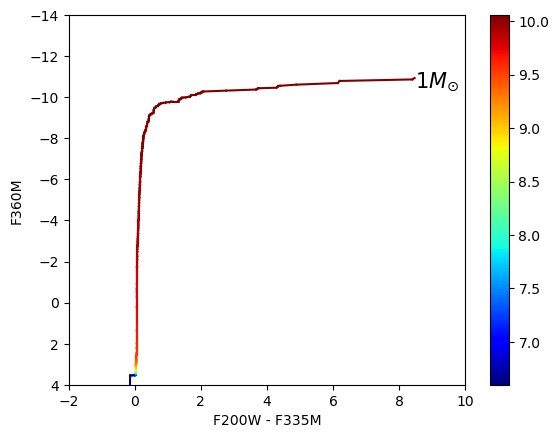

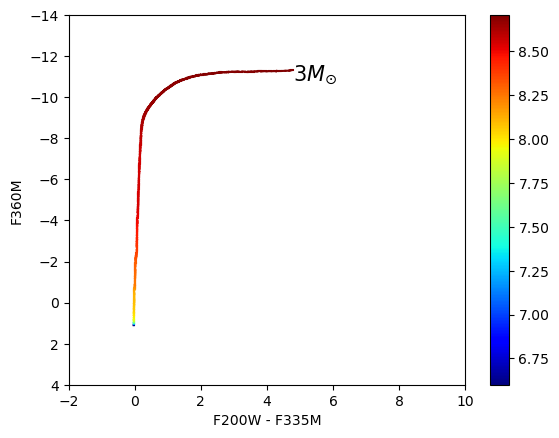

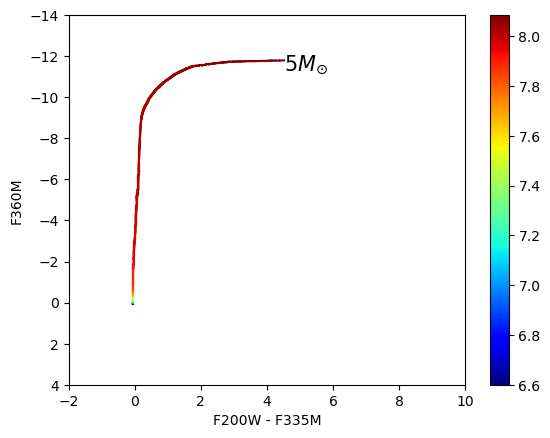

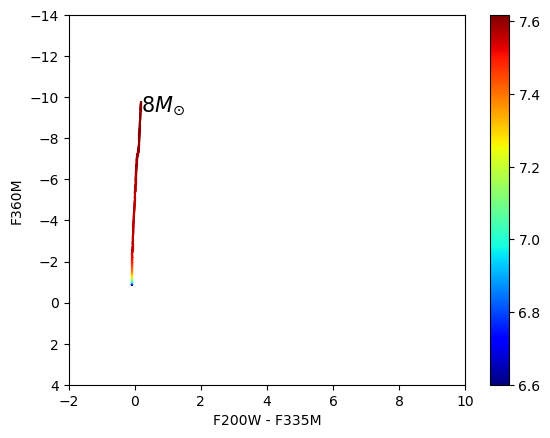

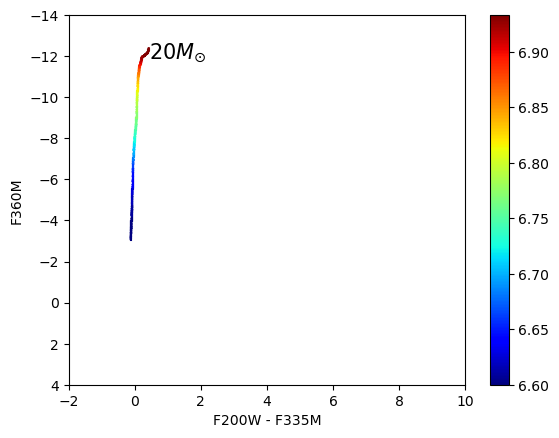

In [ ]:
onesolarmass = Find(isodata, ['Mass >= 0.99', 'Mass <= 1.01'])
plot_isochrone(df=onesolarmass,
               xmodel=['F200W', 'F335M'],
               ymodel='F360M',
               label=1, 
               save=True)

threesolarmass = Find(isodata, ['Mass >= 2.9', 'Mass <= 3.1'])
plot_isochrone(df=threesolarmass,
               xmodel=['F200W', 'F335M'],
               ymodel='F360M',
               label=3,
               save=True)

fivesolarmass = Find(isodata, ['Mass >= 4.9', 'Mass <= 5.1'])
plot_isochrone(df=fivesolarmass,
               xmodel=['F200W', 'F335M'],
               ymodel='F360M',
               label=5,
               save=True)

eightsolarmass = Find(isodata, ['Mass >= 7.9', 'Mass <= 8.1'])
plot_isochrone(df=eightsolarmass,
               xmodel=['F200W', 'F335M'],
               ymodel='F360M',
               label=8,
               save=True)

twentysolarmass = Find(isodata, ['Mass >= 19.9'])
plot_isochrone(df=twentysolarmass,
               xmodel=['F200W', 'F335M'],
               ymodel='F360M',
               label=20,
               save=True)

Text(0.9230000000000005, -11.888, '$20M_{\\odot}$')

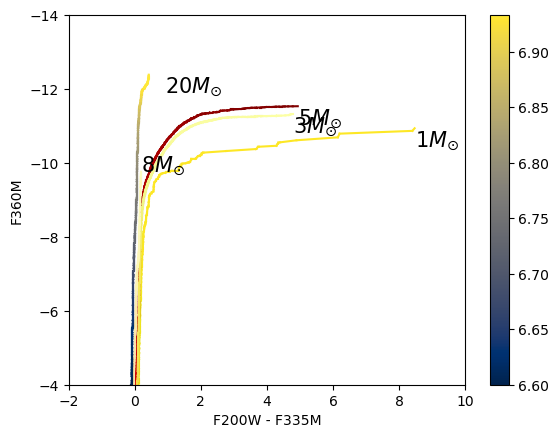

In [252]:
onesolarmass = Find(isodata, ['Mass >= 0.99', 'Mass <= 1.01'])

df = onesolarmass.copy()
df['F200W - F335M'] = df['F200W'].values - df['F335M'].values
# display(onesolarmass)

x = np.sort(np.array(df['F200W - F335M'].values))

y = np.sort(np.array(df['F360M'].values))
y = y[::-1]
# print(y)
z = df['logAge']

fig, ax = plt.subplots()
cmap = plt.cm.viridis
norm = plt.Normalize(z.min(), z.max())
for i in range(len(x)-1):
    ax.plot(x[i:i+2], y[i:i+2], color=cmap(norm(z[i])))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.colorbar(sm, ax=ax)
ax.set_xlim(-2, 10)
ax.set_ylim(-4, -14)
ax.set_xlabel('F200W - F335M')
ax.set_ylabel('F360M')
ax.annotate(r'$1M_{\odot}$', xy=[max(x), min(y)+0.5], size=15)

df = fivesolarmass.copy()
df['F200W - F360M'] = df['F200W'].values - df['F360M'].values
# display(fivesolarmass)

x = np.sort(np.array(df['F200W - F360M'].values))
# print(x)
y = np.sort(np.array(df['F335M'].values))
y = y[::-1]
# print(y)
z = df['logAge']

# fig, ax = plt.subplots()
cmap = plt.cm.jet
norm = plt.Normalize(z.min(), z.max())
for i in range(len(x)-1):
    ax.plot(x[i:i+2], y[i:i+2], color=cmap(norm(z[i])))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.colorbar(sm, ax=ax)
# ax.set_xlim(-2, 6)
# ax.set_ylim(2, -14)
ax.set_xlabel('F200W - F360M')
ax.set_ylabel('F335M')
ax.annotate(r'$5M_{\odot}$', xy=[max(x), min(y)+0.5], size=15)

df = threesolarmass.copy()
df['F200W - F335M'] = df['F200W'].values - df['F335M'].values
# display(df)

x = np.sort(np.array(df['F200W - F335M'].values))
# print(x)
y = np.sort(np.array(df['F360M'].values))
y = y[::-1]
# print(y)
z = df['logAge']

cmap = plt.cm.inferno
norm = plt.Normalize(z.min(), z.max())
for i in range(len(x)-1):
    ax.plot(x[i:i+2], y[i:i+2], color=cmap(norm(z[i])))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.colorbar(sm, ax=ax)
# ax.set_xlim(-2, 6)
# ax.set_ylim(2, -14)
ax.set_xlabel('F200W - F335M')
ax.set_ylabel('F360M')
ax.annotate(r'$3M_{\odot}$', xy=[max(x), min(y)+0.5], size=15)

df = eightsolarmass.copy()
df['F200W - F335M'] = df['F200W'].values - df['F335M'].values
# display(eightsolarmass)

x = np.sort(np.array(df['F200W - F335M'].values))

y = np.sort(np.array(df['F360M'].values))
y = y[::-1]

z = df['logAge']

# fig, ax = plt.subplots()
cmap = plt.cm.magma
norm = plt.Normalize(z.min(), z.max())
for i in range(len(x)-1):
    ax.plot(x[i:i+2], y[i:i+2], color=cmap(norm(z[i])))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.colorbar(sm, ax=ax)
# ax.set_xlim(-2, 6)
# ax.set_ylim(2, -14)
ax.set_xlabel('F200W - F335M')
ax.set_ylabel('F360M')
ax.annotate(r'$8M_{\odot}$', xy=[max(x), min(y)], size=15)

# twentysolarmass = Find(isodata, ['Mass >= 18'])
# twentysolarmass
df = twentysolarmass.copy()
df['F200W - F335M'] = df['F200W'].values - df['F335M'].values
# display(df)

x = np.sort(np.array(df['F200W - F335M'].values))
# print(x)
y = np.sort(np.array(df['F360M'].values))
y = y[::-1]
# print(y)
z = df['logAge']

# fig, ax = plt.subplots()
cmap = plt.cm.cividis
norm = plt.Normalize(z.min(), z.max())
for i in range(len(x)-1):
    ax.plot(x[i:i+2], y[i:i+2], color=cmap(norm(z[i])))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax)
# ax.set_xlim(-2, 6)
# ax.set_ylim(2, -14)
ax.set_xlabel('F200W - F335M')
ax.set_ylabel('F360M')
ax.annotate(r'$20M_{\odot}$', xy=[max(x)+0.5, min(y)+0.5], size=15)

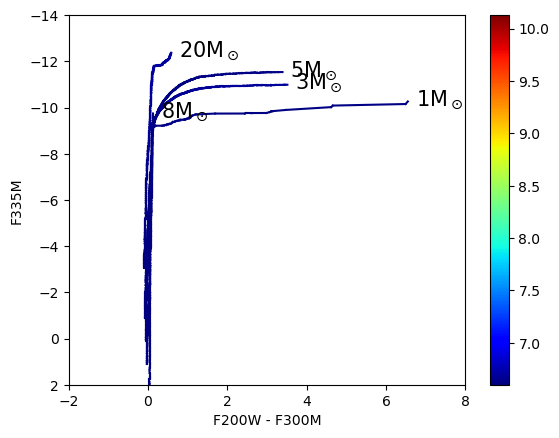

In [ ]:
plot_jwst_cmd(masses=[onesolarmass,
                      threesolarmass,
                      fivesolarmass,
                      eightsolarmass,
                      twentysolarmass],
              xmodel=['F200W', 'F300M'],
              ymodel='F335M',
              xlim=(-2, 8),
              save=True)

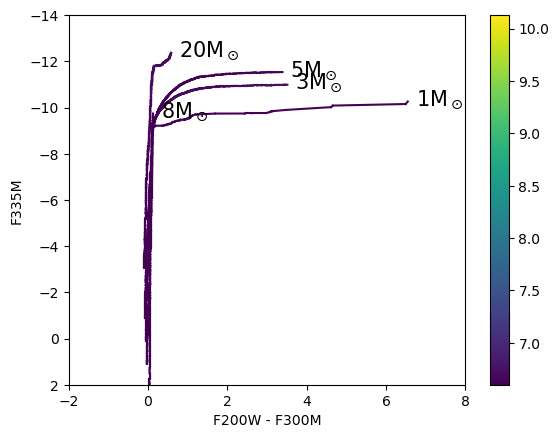

In [268]:
plot_jwst_cmd(masses=[onesolarmass,
                      threesolarmass,
                      fivesolarmass,
                      eightsolarmass,
                      twentysolarmass],
              xmodel=['F200W', 'F300M'],
              ymodel='F335M',
              xlim=(-2, 8),
              cmap = plt.cm.viridis)

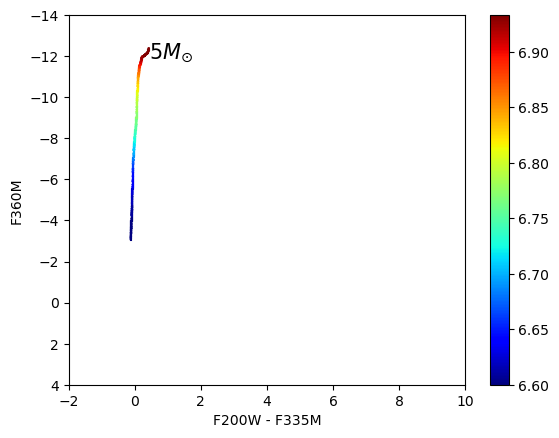

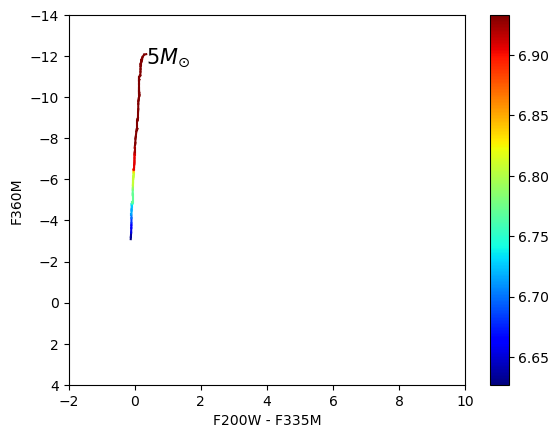

In [25]:
# to check the difference between isochrone with 19.9 <= Mass 
# and isochrone with 19.9 <= Mass <= 21.1
# There is not a lot of visible difference
plot_isochrone(df=models[-1],
               xmodel=['F200W', 'F335M'], 
               ymodel='F360M')

plot_isochrone(df=Find(isodata, ['Mass >= 19.9', 'Mass <= 20.1']),
               xmodel=['F200W', 'F335M'], 
               ymodel='F360M')

In [272]:
data = [onesolarmass, threesolarmass, fivesolarmass, eightsolarmass, twentysolarmass]

print(max(onesolarmass['logAge'].values))
print(max(threesolarmass['logAge'].values))
print(max(fivesolarmass['logAge'].values))
print(max(eightsolarmass['logAge'].values))
print(max(twentysolarmass['logAge'].values))

10.05593
8.70596
8.08497
7.61698
6.98699


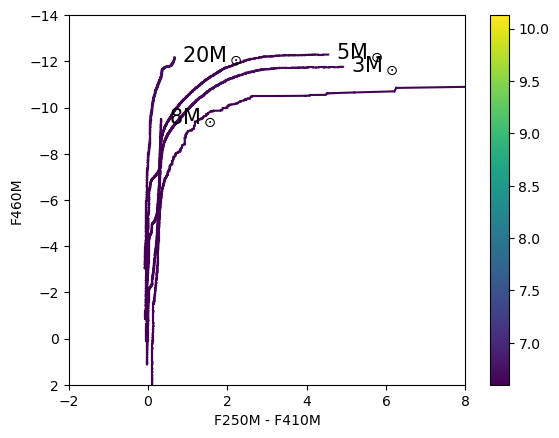

In [287]:
plot_jwst_cmd(masses=[onesolarmass,
                      threesolarmass,
                      fivesolarmass,
                      eightsolarmass,
                      twentysolarmass],
              xmodel=['F250M', 'F410M'],
              ymodel='F460M',
              xlim=(-2, 8),
              cmap = plt.cm.viridis)

## Incorporating JWST models to MakeCMD

Saving the data frames for the cmd query taken from the CMD website. The query had default settings with the step-size of 0.009. One thing to note here is that in the 20solarmass data frame, I am incorporating the data from 19.9 <= Mass. So it contains all the mass ranges from 19.9 up until the end.

In [4]:
headers = "Zini     MH   logAge Mini        int_IMF         Mass   logL    logTe  logg  label   McoreTP C_O  period0  period1  period2  period3  period4  pmode  Mloss  tau1m   X   Y   Xc  Xn  Xo  Cexcess  Z 	 mbolmag  F070W  F090W F115W  F150W  F200W  F277W  F356W F444W  F150W2  F322W2  F140M F162M  F182M  F210M F250M  F300M  F335M  F360M  F410M  F430M F460M  F480M"
names=[i for i in headers.split(" ") if i != "" and i != "\t"]
isodata = pd.read_csv("isochrone-query-step-0_009.dat", delim_whitespace=True, comment="#", names=names)
isodata["ID"] = [i for i in range(len(isodata))]

onesolarmass = Find(isodata, ['Mass >= 0.99', 'Mass <= 1.01'])
onesolarmass.to_csv('isoNIRCAM_1Msun.frame')

threesolarmass = Find(isodata, ['Mass >= 2.9', 'Mass <= 3.1'])
threesolarmass.to_csv('isoNIRCAM_3Msun.frame')

fivesolarmass = Find(isodata, ['Mass >= 4.9', 'Mass <= 5.1'])
fivesolarmass.to_csv('isoNIRCAM_5Msun.frame')

eightsolarmass = Find(isodata, ['Mass >= 7.9', 'Mass <= 8.1'])
eightsolarmass.to_csv('isoNIRCAM_8Msun.frame')

twentysolarmass = Find(isodata, ['Mass >= 19.9'])
twentysolarmass.to_csv('isoNIRCAM_20Msun.frame')

isodata.to_csv('isoNIRCAM_all.frame')

In [ ]:
wfc3_masses = [pd.read_csv("isoWFC3_1Msun.frame"), pd.read_csv("isoWFC3_3Msun.frame"), pd.read_csv("isoWFC3_5Msun.frame"),
	       pd.read_csv("isoWFC3_8Msun.frame"), pd.read_csv("isoWFC3_20Msun.frame")]

acs_masses = [pd.read_csv("isoACS_WFC_1Msun.frame"), pd.read_csv("isoACS_WFC_3Msun.frame"), pd.read_csv("isoACS_WFC_5Msun.frame"),
	      pd.read_csv("isoACS_WFC_8Msun.frame"), pd.read_csv("isoACS_WFC_20Msun.frame")]

nircam_masses = [pd.read_csv('isoNIRCAM_1Msun.frame'),
                 pd.read_csv('isoNIRCAM_3Msun.frame'),
                 pd.read_csv('isoNIRCAM_5Msun.frame'),
                 pd.read_csv('isoNIRCAM_8Msun.frame'),
                 pd.read_csv('isoNIRCAM_20Msun.frame')]
                 
isoacs = pd.read_csv("isoACS_all.frame")
isowfc3 = pd.read_csv("isoWFC3_all.frame")

## Updating `MakeCMD()` to incorporate JWST models

In [7]:
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

DaoCleanMatch = LoadSources(chandra_jwst_dir+'M66_daoclean_matches.frame')

dist = 10.1e6
dmod = 5 * np.log(dist) - 5

DaoCleanPhots = GetDaoPhots(DaoCleanMatch, 
                            photfiles=[jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
                                       jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
                                       jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
                                       jwstdir+'photometry_M66_f360m_nircam_sources.ecsv'],
                            idheads=['F200W ID', 'F300M ID', 'F335M ID', 'F360M ID'],
                            filters=['F200W', 'F300M', 'F335M', 'F360M'],
                            magheader='aperture_mag_corr',
                            dmod=dmod,
                            return_err=True)

display(DaoCleanPhots)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_daoclean_matches.frame...
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv


,RA,Dec,F200W ID,F300M ID,F335M ID,F360M ID,CSC ID,F200W,F200W Err,F300M,F300M Err,F335M,F335M Err,F360M,F360M Err
0,170.062403,12.991447,186126,43256.0,39563.0,NaN,2CXO J112014.9+125929,-60.952555,-0.104048,-61.983520,-0.029836,-62.404560,-0.023996,NaN,NaN
1,170.062377,12.991509,186591,43256.0,NaN,45349.0,2CXO J112014.9+125929,-60.864771,-0.112812,-61.983520,-0.029836,NaN,NaN,-62.163170,-0.029958
2,170.062923,12.991314,185199,42999.0,39292.0,44947.0,2CXO J112015.0+125928,-59.560697,-0.296408,-60.805366,-0.088302,-61.071716,-0.081888,-61.055412,-0.083097
3,170.062862,12.991339,185366,43115.0,39406.0,45067.0,2CXO J112015.0+125928,-60.045883,-0.200001,-61.265531,-0.057798,-61.585077,-0.051037,-61.577704,-0.051366
4,170.062923,12.991353,185433,NaN,NaN,NaN,2CXO J112015.0+125928,-59.619006,-0.286530,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,170.054172,12.960079,26276,NaN,NaN,NaN,2CXO J112013.0+125736,-54.343130,-0.421119,NaN,NaN,NaN,NaN,NaN,NaN
1429,170.054284,12.960093,26305,NaN,NaN,NaN,2CXO J112013.0+125736,-54.006644,-0.574976,NaN,NaN,NaN,NaN,NaN,NaN
1430,170.054191,12.960178,26519,6497.0,5610.0,6873.0,2CXO J112013.0+125736,-55.434431,-0.154548,-54.644785,-0.743486,-55.189034,-0.670797,-55.183692,-0.606542
1431,170.054263,12.960223,26624,NaN,5634.0,6902.0,2CXO J112013.0+125736,-52.810427,-1.736334,NaN,NaN,-54.729536,-1.022644,-55.028181,-0.700647


In [9]:
xrbs = DaoCleanPhots.copy()
xrbs.head()

,RA,Dec,F200W ID,F300M ID,F335M ID,F360M ID,CSC ID,F200W,F200W Err,F300M,F300M Err,F335M,F335M Err,F360M,F360M Err
0,170.062403,12.991447,186126,43256.0,39563.0,NaN,2CXO J112014.9+125929,-60.952555,-0.104048,-61.983520,-0.029836,-62.404560,-0.023996,NaN,NaN
1,170.062377,12.991509,186591,43256.0,NaN,45349.0,2CXO J112014.9+125929,-60.864771,-0.112812,-61.983520,-0.029836,NaN,NaN,-62.163170,-0.029958
2,170.062923,12.991314,185199,42999.0,39292.0,44947.0,2CXO J112015.0+125928,-59.560697,-0.296408,-60.805366,-0.088302,-61.071716,-0.081888,-61.055412,-0.083097
3,170.062862,12.991339,185366,43115.0,39406.0,45067.0,2CXO J112015.0+125928,-60.045883,-0.200001,-61.265531,-0.057798,-61.585077,-0.051037,-61.577704,-0.051366
4,170.062923,12.991353,185433,NaN,NaN,NaN,2CXO J112015.0+125928,-59.619006,-0.286530,NaN,NaN,NaN,NaN,NaN,NaN


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F300M'>)

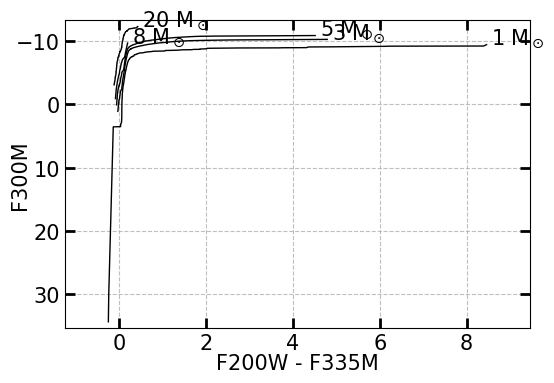

In [11]:
def MakeCMD(sources=False, xcolor=None, ycolor=None, xmodel=None, ymodel=None, figsize=(6,4), xlim=None, ylim=None, color="black", size=10, marker=None, label=None, save=False, savefile=None, title=None, subimg=None, annotation=None, annotation_size=None, imshow=True, fontsize=15, shift_labels=[[0,0],[0,0],[0,0],[0,0],[0,0]], set_labels=None, instrument="ACS", color_correction=[0,0], labelpoints=False, file_dir=False): 

    """Makes a CMD from a given set of points, either from a list or an input dataframe.

    PARAMETERS: 
    sources     [pd.dataframe, list]:     Input may either be a pandas dataframe containing the appropriate magnitudes required for the CMD, 
                               or a list of coordinates in the format [[xs],[ys]]. 
    xcolor         [str or list]:         The name of the color or magnitude to plot in the x-axis, as it is labeled in the dataframe. 
                        This will be the default x-axis label. If a list is given, it is assumed to contain the 
                        column names of the input dataframe to be subtracted (e.g. F555W - F814W)
    ycolor         [str or list]:         The name of the color or magnitude to plot in the y-axis, as it is labeled in the dataframe. 
                        This will be the default y-axis label. If a list is given, it is assumed to contain the column 
                        names of the input dataframe to be subtracted (e.g. F555W - F814W)
    xmodel         [str or list]:         The magnitude(s) of the filter(s) to be used from the stellar models for the x-axis. 
                        If given as a list, it is assumed the color is xmodel[0] - xmodel[1] 
    ymodel         [str or list]:         The magnitude(s) of the filter(s) to be used from the stellar models for the y-axis. 
                        If given as a list, it is assumed the color is ymodel[0] - ymodel[1] 
    figsize     [tuple] (6,4):         The desired dimensions of the figure. 
    xlim         [tuple] (None):        The limits on the x-axis. If none are given, the limits are assumed to be the (xmin - 1, xmax + 1) 
    ylim         [tuple] (None):        The limits on the y-axis. If none are given, the limits are assumed to be (ymax + 1, ymin - 1)
    color         [str] ("black"):     Marker color
    size         [int] (10):         Marker size
    marker         [str] (None):        The style of the marker. Defaults to a filled point. If "o" is given, 
                        the marker is set to be an open circle. 
    label         [str] (None):        The legend label to assign to the input points from sources. 
    save         [bool] (False):     Sets whether to automatically same the CMD image. 
    savefile     [str] (None):         The name to assigned the saved CMD image. 
    title         [str] (None):         Title of the figure.
    subimg         [str] (None):         Filename of an image to include in the corner of the CMD. 
                        This is to allow a subplot of the XRB plotted to be shown within the CMD. 
    annotation     [str] (None):         Additional annotation to add to the bottom corner of the CMD (usually XRB ID)
    annotation_size [int] (None):         Annotation fontsize 
    imshow         [bool] (True):         Shows the plot.
    fontsize     [int] (20):         The fontsize of text other than the annoations
    shift_labels     [list]:         List of x and y coordinate distances by which to shift each of the model mass labels.
                        Defaults to [[0,0],[0,0],[0,0],[0,0],[0,0]] (no shifts)
    set_labels     [list] (None):        Sets the position of labels. If none is given, positions are automatically calculated.
    instrument     [str] ("ACS"):         Name of the instrument used, to determine which models to call. 
    color_correction [list] ([0,0]):    Corrections on the x and y position of the sources. Defaults to no correction. 
    labelpoints     [list] (False):     Labels to add to each point. If none are given, defaults to False and no labels added. 
    file_dir     [str]:             The directory within which the models may be found. By default, the 
                        code attempts to find this automatically, but if it fails, it will 
                        prompt the user to input the directory manually. 

    RETURNS: 
    f, ax:         Arguments defining the figure, which can be used to add more points to the CMD after the initial plotting.
 
    """
    curr_dir = pwd()

    if instrument.upper() =="WFC3": masses = wfc3_masses # list of DataFrames of each mass model
    elif instrument.upper() == "ACS": masses = acs_masses
    else: masses = nircam_masses
    mass_labels = [r"1 M$_\odot$", r"3 M$_\odot$", r"5 M$_\odot$", r"8 M$_\odot$", r"20 M$_\odot$"]

    #cd(curr_dir) 

    if savefile: save = True

    # Setting the x- and y-axes labels.
    # if xcolor and/or ycolor is a list, will need to set color[0] - color[1] as the color of the appropriate axis
    if not xcolor: xcolor=xmodel
    if not ycolor: ycolor=ymodel

    if isinstance(xcolor, list): xlabel = " - ".join(xcolor)
    else: xlabel = xcolor
    if isinstance(ycolor, list): ylabel = " - ".join(ycolor)
    else: ylabel = ycolor

    ### Pulling the x and y values of the sources ###
    # if input source is a pandas dataframe, read in the appropriate colors and magnitudes (and add correction, if needed)
    if isinstance(sources, pd.DataFrame):
        if isinstance(xcolor, list): xsources = sources[xcolor[0]].values - sources[xcolor[1]].values + color_correction[0]
        else: xsources = sources[xcolor].values + color_correction[0]
        if isinstance(ycolor, list): ysources = sources[ycolor[0]].values - sources[ycolor[1]].values + color_correction[1]
        else: ysources = sources[ycolor].values + color_correction[1]
        
    elif sources: # If sources is a list or coordinates, pull the x and y values as given (with additional color correction)
        xsources = (np.array(sources[0]) + color_correction[0]).tolist()
        ysources = (np.array(sources[1]) + color_correction[1]).tolist()    
    ### Will only need to call xsources or ysources from now on ###

    
    ### PLOTTING MODEL MASS TRACKS ###

    f, ax = plt.subplots(figsize=figsize)

    # Setting the tick parameters
    ax.tick_params(direction="in", labelsize=15, bottom=True, \
               top=True, left=True, right=True, length=7, width=2)
    ax.grid(alpha=0.8, linestyle="--")

    # If no xmodel or ymodel are given, default to that of the sources. 
    # This point will fail if the filters of the sources are not given a name corresponding to the filters in the model DataFrame!
    if not xmodel: xmodel=xcolor
    if not ymodel: ymodel=ycolor

    # Pulling the correct colors/magnitudes from the models and plotting
    # and setting the default mass track label position and plot limits
    xlims = []
    ylims = []
    for m, mass in enumerate(masses): # for each of the mass models, pull the color/mag given by xmodel and ymodel
        if isinstance(xmodel, list):
            if instrument.upper() == 'NIRCAM':
                xtemp = np.sort(np.array(mass[xmodel[0]].values - mass[xmodel[1]].values)) # sort in ascending order
            else: 
                xtemp = mass[xmodel[0]].values - mass[xmodel[1]].values
            xtemp_left = max(xtemp)    # Keeping track of the leftmost x coordinate        
            xtemp_label = max(xtemp) + 0.1 + shift_labels[m][0] # default mass label position, unless set_labels is given
            if not xlim: xlims.append([min(xtemp)-1, max(xtemp)+1])
            invert_xlim = False
        else: # if x-axis is a magnitude..
            if instrument.upper() == 'NIRCAM':
                xtemp = np.sort(np.array(mass[xmodel].values))
            else:
                xtemp = mass[xmodel].values
            xtemp_label = min(xtemp) - 0.1 + shift_labels[m][0]
            xtemp_left = min(xtemp)
            if not xlim: xlims.append([max(xtemp)+1, min(xtemp)-1])
            invert_xlim = True
        if isinstance(ymodel, list): 
            ytemp = mass[ymodel[0]].values - mass[ymodel[1]].values
            if not ylim: ylims.append([min(ytemp)-1, max(ytemp)+1])
            invert_ylim = False
        else: # of y-axis is a magnitude...
            if instrument.upper() == 'NIRCAM':
                ytemp = np.sort(np.array(mass[ymodel].values))
                ytemp = ytemp[::-1]
                invert_ylim = False
                ytemp_label = ytemp[xtemp.tolist().index(xtemp_left)] + shift_labels[m][1]
            else:
                ytemp = mass[ymodel].values
                invert_ylim = True
                ytemp_label = ytemp[xtemp.tolist().index(xtemp_left)] + invert_ylim*0.5 + shift_labels[m][1]
            if not ylim: ylims.append([max(ytemp)+1, min(ytemp)-1])
            # # Finding the best y-coordinate for the model label based on the leftmost
            # ytemp_label = ytemp[xtemp.tolist().index(xtemp_left)] + invert_ylim*0.5 + shift_labels[m][1]
        # If set_labels is given, use this as the coordinate of the label
        # (overrides the label positions set above)
        if set_labels: 
            xtemp_label = set_labels[m][0]
            ytemp_label = set_labels[m][1]

        # Plotting mass track and mass label
        plt.plot(xtemp, ytemp, color="black", lw=1)
        ax.annotate(mass_labels[m], xy=(xtemp_label, ytemp_label), size=15)

    xlims = np.array(xlims)
    ylims = np.array(ylims) 


    # PLOTTING SOURCE POINTS
    if isinstance(sources, pd.DataFrame) or isinstance(sources, list): 
        if marker == "o":     # 'o' used for open circle 
            ax.scatter(xsources, ysources, facecolor="none", edgecolor=color, s=size, label=label)
        elif marker == None:     # default is a closed circle 
            ax.scatter(xsources, ysources, color=color, s=size, label=label)
        else: 
            ax.scatter(xsources, ysources, color=color, s=size, label=label, marker=marker)

        # PLOTTING POINT NAMES, IF GIVEN
        if labelpoints: 
            for i in range(len(labelpoints)): 
                ax.annotate(labelpoints[i], xy=[xsources[i], ysources[i]-.2], size=10, horizontalalignment="center")

    # Setting plot limits

    if not xlim:
            if invert_xlim: plt.xlim(max(xlims.T[0]), min(xlims.T[1]))
            else: plt.xlim(min(xlims.T[0]), max(xlims.T[1]))
    else: plt.xlim(xlim)
    if not ylim: 
            if invert_ylim: plt.ylim(max(ylims.T[0]), min(ylims.T[1]))
            elif instrument.upper() == "NIRCAM": plt.ylim(ylims.max(), ylims.min())
            else: plt.ylim(min(ylims.T[0]), max(ylims.T[1]))
    else: plt.ylim(ylim)

    # plotting mass track labels
    plt.xlabel(xlabel, labelpad=0, fontsize=fontsize)#, labelparams, labelpad=0)
    plt.ylabel(ylabel, labelpad=-10, fontsize=fontsize)#, labelparams, labelpad=-10)

    # If another title (such as name of the object) is given, plot
    # Adjusts size to make it fit the size of the plot
    if 0.6*figsize[0]*figsize[1] > 30: titlesize = 30
    else: titlesize = 0.6*figsize[0]*figsize[1]

    if not annotation_size: annotation_size = titlesize

    if title: ax.set_title(title, fontsize=titlesize)

    # If an annotation is given, add it to the bottom of the figure
    if annotation: ax.annotate(annotation, xy=(xlim[1]-0.05*abs(xlim[1]), ylim[0]-0.1*abs(ylim[1])), size=annotation_size, horizontalalignment="right")

    # if a subimage is given as a filename, read in. 
    if subimg and "." in subimg: 
        subimg = img.imread(subimg)

    # If an image is passed to overlay on plot, add 
    if hasattr(subimg, 'shape'): # tests if subimg was fed in
        try: 
            XY = [figsize[0], figsize[1]]
            ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
            ax2.imshow(subimg)
            ax2.axis('off')
        except: 
            im = plt.imread(subimg)
            XY = [figsize[0], figsize[1]]
            ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
            ax2.imshow(im)
            ax2.axis('off')

    # saving image, if prompted
    if savefile != None: save = True; pass;
    if save:
        if savefile == None: 
            savefile = df["ID"][0].split("X")[0] + "_" + xcolors + "_" + ycolors
        plt.savefig(savefile.split(".")[0]+".jpg", dpi=300, bbox_inches="tight")

    # Returning plot information, in case I need this later
    # need to retrieve ax if using both subimg followed by AddCMD

    cd(curr_dir)
    return f, ax

MakeCMD(xmodel=['F200W', 'F335M'],
        ymodel='F300M',
        instrument='nircam')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F300M', ylabel='F335M'>)

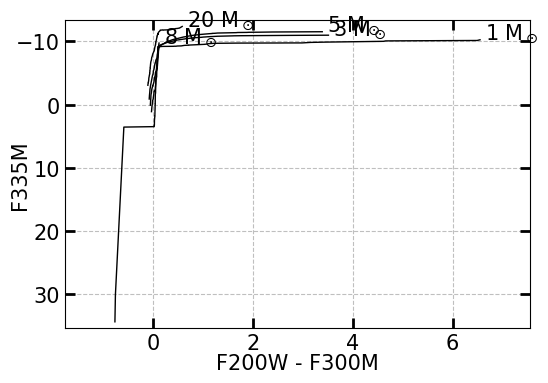

In [12]:
MakeCMD(xmodel=['F200W', 'F300M'],
        ymodel='F335M',
        instrument='nircam')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F335M - F360M', ylabel='F200W'>)

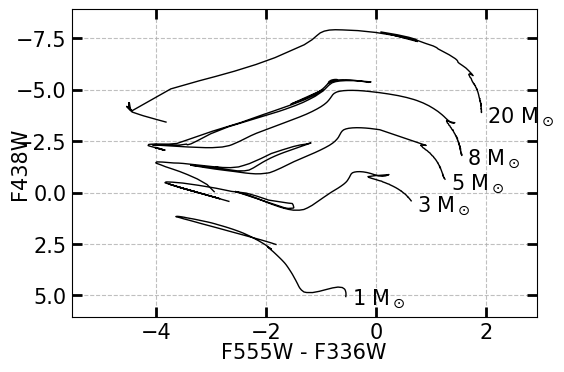

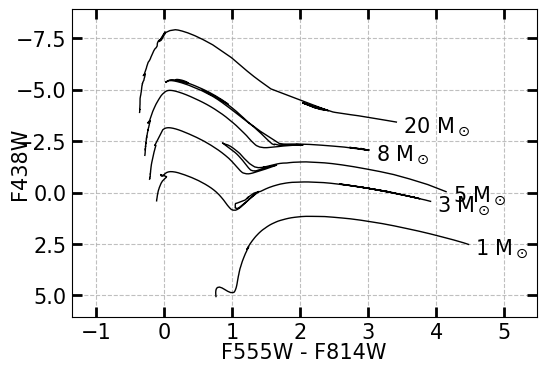

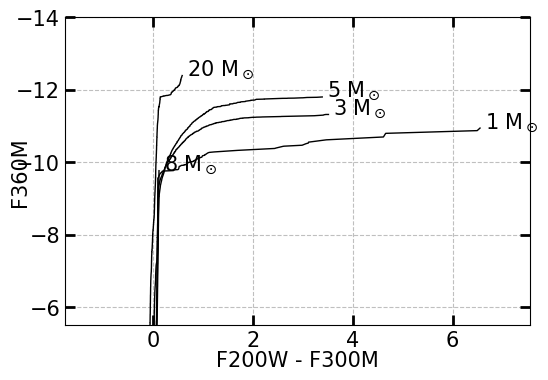

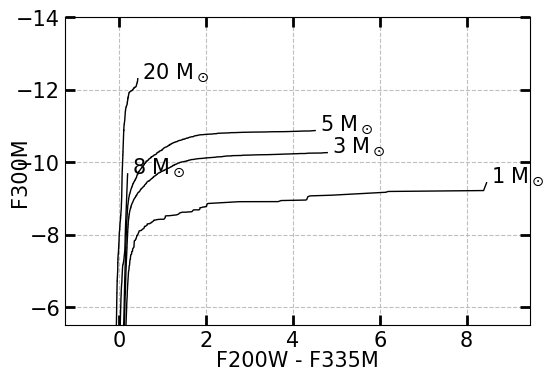

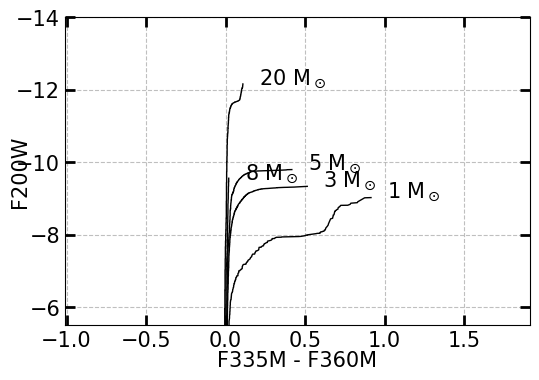

In [13]:
# Testing HST models 
MakeCMD(xmodel=['F555W', 'F336W'],
        ymodel='F438W',
        instrument='wfc3')
MakeCMD(xmodel=['F555W', 'F814W'],
        ymodel='F438W',
        instrument='wfc3')

# Testing JWST models
MakeCMD(xmodel=['F200W', 'F300M'],
        ymodel='F360M',
        instrument='nircam',
        ylim=(-5.5, -14))

MakeCMD(xmodel=['F200W', 'F335M'],
        ymodel='F300M',
        instrument='nircam',
        ylim=(-5.5, -14))

MakeCMD(xmodel=['F335M', 'F360M'],
        ymodel='F200W',
        instrument='nircam',
        ylim=(-5.5, -14))

In [157]:
headers = "Zini     MH   logAge Mini        int_IMF         Mass   logL    logTe  logg  label   McoreTP C_O  period0  period1  period2  period3  period4  pmode  Mloss  tau1m   X   Y   Xc  Xn  Xo  Cexcess  Z 	 mbolmag  F070Wmag  F090Wmag  F115Wmag  F150Wmag  F200Wmag  F277Wmag  F356Wmag  F444Wmag  F150W2mag  F322W2mag  F140Mmag  F162Mmag  F182Mmag  F210Mmag  F250Mmag  F300Mmag  F335Mmag  F360Mmag  F410Mmag  F430Mmag  F460Mmag  F480Mmag"
names=[i for i in headers.split(" ") if i != "" and i != "\t"]
isoTemp = pd.read_csv("isochrone-query-step-0_009.dat", delim_whitespace=True, comment="#", names=names)
isoTemp["ID"] = [i for i in range(len(isoTemp))]
display(isoTemp)
onesolarmass = Find(isoTemp, 'Mass == 1.0')
display(onesolarmass)

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210Mmag,F250Mmag,F300Mmag,F335Mmag,F360Mmag,F410Mmag,F430Mmag,F460Mmag,F480Mmag,ID
0,0.0152,0.01508,6.60000,0.090000,1.081690,0.090,-1.674,3.4146,3.676,0,...,6.044,5.998,5.873,5.579,5.381,5.236,5.283,5.334,5.315,0
1,0.0152,0.01508,6.60000,0.090446,1.085948,0.090,-1.672,3.4147,3.677,0,...,6.040,5.994,5.869,5.575,5.377,5.232,5.279,5.330,5.311,1
2,0.0152,0.01508,6.60000,0.104545,1.207988,0.105,-1.617,3.4202,3.707,0,...,5.908,5.864,5.740,5.449,5.254,5.110,5.155,5.207,5.189,2
3,0.0152,0.01508,6.60000,0.112700,1.269209,0.113,-1.583,3.4236,3.719,0,...,5.830,5.786,5.663,5.377,5.184,5.042,5.086,5.137,5.119,3
4,0.0152,0.01508,6.60000,0.120294,1.321247,0.120,-1.566,3.4252,3.737,0,...,5.792,5.748,5.626,5.342,5.151,5.009,5.052,5.104,5.086,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157895,0.0152,0.01508,10.12793,0.956423,2.463313,0.658,3.238,3.4959,-0.046,7,...,-6.585,-6.304,-6.575,-6.745,-6.801,-6.729,-6.616,-6.535,-6.591,157895
157896,0.0152,0.01508,10.12793,0.956423,2.463313,0.652,3.286,3.4890,-0.126,7,...,-6.741,-6.439,-6.707,-6.907,-6.973,-6.901,-6.784,-6.707,-6.765,157896
157897,0.0152,0.01508,10.12793,0.956423,2.463313,0.642,3.330,3.4829,-0.201,7,...,-6.879,-6.558,-6.821,-7.053,-7.132,-7.063,-6.941,-6.871,-6.928,157897
157898,0.0152,0.01508,10.12793,0.956424,2.463314,0.627,3.359,3.4799,-0.253,7,...,-6.969,-6.639,-6.902,-7.150,-7.234,-7.167,-7.045,-6.978,-7.035,157898


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210Mmag,F250Mmag,F300Mmag,F335Mmag,F360Mmag,F410Mmag,F430Mmag,F460Mmag,F480Mmag,ID
0,0.0152,0.01508,6.60000,1.000000,2.472915,1.0,-0.110,3.6495,4.098,0,...,2.742,2.800,2.707,2.698,2.693,2.689,2.716,2.811,2.792,47
1,0.0152,0.01508,6.60900,1.000000,2.472915,1.0,-0.117,3.6494,4.104,0,...,2.757,2.815,2.722,2.713,2.708,2.704,2.731,2.826,2.807,431
2,0.0152,0.01508,6.61800,1.000000,2.472915,1.0,-0.123,3.6493,4.110,0,...,2.772,2.830,2.737,2.728,2.723,2.718,2.746,2.841,2.822,828
3,0.0152,0.01508,6.62700,1.000000,2.472915,1.0,-0.128,3.6492,4.115,0,...,2.785,2.842,2.750,2.741,2.735,2.731,2.759,2.854,2.835,1228
4,0.0152,0.01508,6.63600,1.000000,2.472915,1.0,-0.134,3.6491,4.120,0,...,2.798,2.855,2.763,2.754,2.748,2.744,2.772,2.867,2.848,1620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,0.0152,0.01508,10.04693,1.003719,2.473691,1.0,1.620,3.6498,2.370,3,...,-1.572,-1.482,-1.621,-1.634,-1.639,-1.644,-1.616,-1.492,-1.508,155611
415,0.0152,0.01508,10.04693,1.003852,2.473718,1.0,1.667,3.6470,2.311,3,...,-1.710,-1.615,-1.759,-1.773,-1.778,-1.784,-1.754,-1.626,-1.642,155612
416,0.0152,0.01508,10.04693,1.003969,2.473742,1.0,1.713,3.6443,2.254,3,...,-1.842,-1.742,-1.892,-1.907,-1.912,-1.918,-1.887,-1.754,-1.770,155613
417,0.0152,0.01508,10.04693,1.004079,2.473765,1.0,1.759,3.6414,2.197,3,...,-1.978,-1.872,-2.028,-2.044,-2.049,-2.055,-2.023,-1.885,-1.902,155614


,Unnamed: 0,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,280,0.0152,0.01508,8.58896,3.185855,2.598236,1.007,4.146,3.3395,-1.395,...,-5.380,-5.815,-8.013,-9.229,-9.725,-10.286,-10.363,-10.508,-10.695,80749
1,281,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.146,3.3410,-1.393,...,-5.310,-5.757,-7.981,-9.205,-9.704,-10.271,-10.351,-10.499,-10.687,80750
2,282,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.313,3.2167,-2.058,...,0.952,-0.479,-4.973,-6.876,-7.660,-8.797,-9.130,-9.545,-9.876,80751
3,283,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.220,3.2859,-1.688,...,-2.530,-3.414,-6.648,-8.174,-8.800,-9.621,-9.813,-10.079,-10.331,80752
4,284,0.0152,0.01508,8.58896,3.185857,2.598236,0.996,4.119,3.3613,-1.286,...,-6.135,-6.435,-8.329,-9.449,-9.908,-10.392,-10.435,-10.549,-10.717,80753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,1343,0.0152,0.01508,10.05593,0.998905,2.472686,0.992,2.128,3.6167,1.725,...,-3.044,-2.896,-3.101,-3.122,-3.130,-3.135,-3.096,-2.907,-2.935,155884
701,1344,0.0152,0.01508,10.05593,0.998953,2.472696,0.991,2.172,3.6136,1.668,...,-3.170,-3.020,-3.228,-3.249,-3.258,-3.262,-3.222,-3.029,-3.059,155885
702,1345,0.0152,0.01508,10.05593,0.998995,2.472705,0.991,2.214,3.6106,1.614,...,-3.291,-3.139,-3.349,-3.371,-3.380,-3.383,-3.342,-3.146,-3.177,155886
703,1346,0.0152,0.01508,10.05593,0.999035,2.472713,0.990,2.258,3.6074,1.558,...,-3.415,-3.264,-3.475,-3.497,-3.507,-3.507,-3.465,-3.268,-3.302,155887


,Unnamed: 0,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,280,0.0152,0.01508,8.58896,3.185855,2.598236,1.007,4.146,3.3395,-1.395,...,-5.380,-5.815,-8.013,-9.229,-9.725,-10.286,-10.363,-10.508,-10.695,80749
1,281,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.146,3.3410,-1.393,...,-5.310,-5.757,-7.981,-9.205,-9.704,-10.271,-10.351,-10.499,-10.687,80750
2,282,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.313,3.2167,-2.058,...,0.952,-0.479,-4.973,-6.876,-7.660,-8.797,-9.130,-9.545,-9.876,80751
3,283,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.220,3.2859,-1.688,...,-2.530,-3.414,-6.648,-8.174,-8.800,-9.621,-9.813,-10.079,-10.331,80752
4,284,0.0152,0.01508,8.58896,3.185857,2.598236,0.996,4.119,3.3613,-1.286,...,-6.135,-6.435,-8.329,-9.449,-9.908,-10.392,-10.435,-10.549,-10.717,80753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,1343,0.0152,0.01508,10.05593,0.998905,2.472686,0.992,2.128,3.6167,1.725,...,-3.044,-2.896,-3.101,-3.122,-3.130,-3.135,-3.096,-2.907,-2.935,155884
701,1344,0.0152,0.01508,10.05593,0.998953,2.472696,0.991,2.172,3.6136,1.668,...,-3.170,-3.020,-3.228,-3.249,-3.258,-3.262,-3.222,-3.029,-3.059,155885
702,1345,0.0152,0.01508,10.05593,0.998995,2.472705,0.991,2.214,3.6106,1.614,...,-3.291,-3.139,-3.349,-3.371,-3.380,-3.383,-3.342,-3.146,-3.177,155886
703,1346,0.0152,0.01508,10.05593,0.999035,2.472713,0.990,2.258,3.6074,1.558,...,-3.415,-3.264,-3.475,-3.497,-3.507,-3.507,-3.465,-3.268,-3.302,155887


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,8.58896,3.185855,2.598236,1.007,4.146,3.3395,-1.395,8,...,-5.380,-5.815,-8.013,-9.229,-9.725,-10.286,-10.363,-10.508,-10.695,80749
1,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.146,3.3410,-1.393,8,...,-5.310,-5.757,-7.981,-9.205,-9.704,-10.271,-10.351,-10.499,-10.687,80750
2,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.313,3.2167,-2.058,8,...,0.952,-0.479,-4.973,-6.876,-7.660,-8.797,-9.130,-9.545,-9.876,80751
3,0.0152,0.01508,8.58896,3.185857,2.598236,0.997,4.220,3.2859,-1.688,8,...,-2.530,-3.414,-6.648,-8.174,-8.800,-9.621,-9.813,-10.079,-10.331,80752
4,0.0152,0.01508,8.58896,3.185857,2.598236,0.996,4.119,3.3613,-1.286,8,...,-6.135,-6.435,-8.329,-9.449,-9.908,-10.392,-10.435,-10.549,-10.717,80753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,0.0152,0.01508,10.05593,0.998905,2.472686,0.992,2.128,3.6167,1.725,3,...,-3.044,-2.896,-3.101,-3.122,-3.130,-3.135,-3.096,-2.907,-2.935,155884
701,0.0152,0.01508,10.05593,0.998953,2.472696,0.991,2.172,3.6136,1.668,3,...,-3.170,-3.020,-3.228,-3.249,-3.258,-3.262,-3.222,-3.029,-3.059,155885
702,0.0152,0.01508,10.05593,0.998995,2.472705,0.991,2.214,3.6106,1.614,3,...,-3.291,-3.139,-3.349,-3.371,-3.380,-3.383,-3.342,-3.146,-3.177,155886
703,0.0152,0.01508,10.05593,0.999035,2.472713,0.990,2.258,3.6074,1.558,3,...,-3.415,-3.264,-3.475,-3.497,-3.507,-3.507,-3.465,-3.268,-3.302,155887


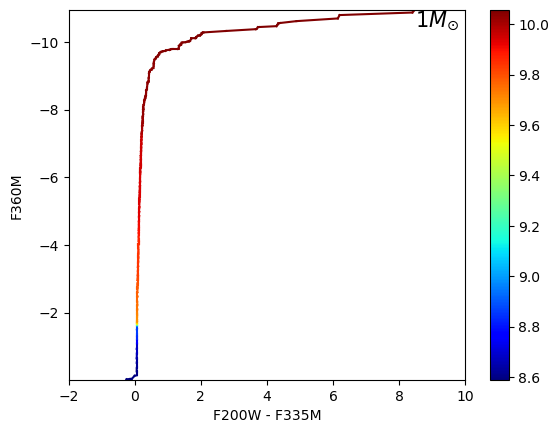

In [190]:
# onesolarmass = Find(isodata, 'Mass == 1.0')
# display(onesolarmass)

# plot_isochrone(df=onesolarmass,
#                xmodel=['F200W', 'F335M'],
#                ymodel='F360M',
#                label=1)

display(nircam_masses[0])

test = Find(nircam_masses[0], 'F360M <= 0')
display(test)

onesolarmass = Find(isodata, ['Mass >= 0.99', 'Mass <= 1.01', 'F360M <= 0'])
display(onesolarmass)
plot_isochrone(df=test,
               xmodel=['F200W', 'F335M'],
               ymodel='F360M',
               label=1)

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

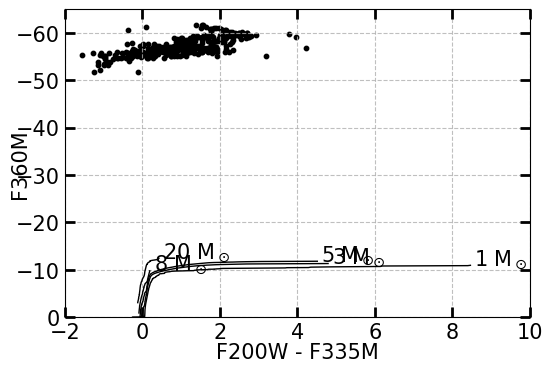

In [211]:
M66dir = '/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/'
MakeCMD(sources=xrbs,
        xcolor=['F200W', 'F335M'],
        ycolor='F360M',
        instrument='NIRCAM',
        ylim=(0, -65),
        xlim=(-2, 10),
        save=True,
        savefile=M66dir+'F360M_vs_F200W-F335M_CMD.png')

(<Figure size 600x400 with 1 Axes>, <Axes: xlabel='F200W', ylabel='F300M'>)

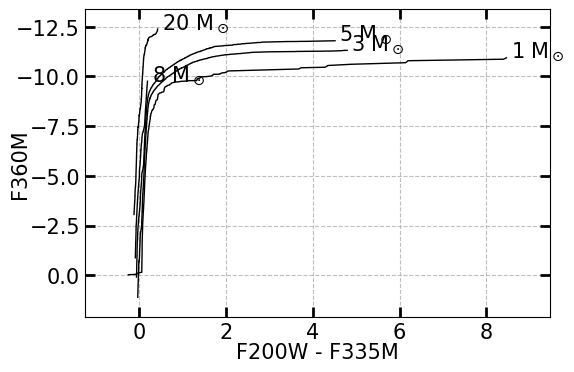

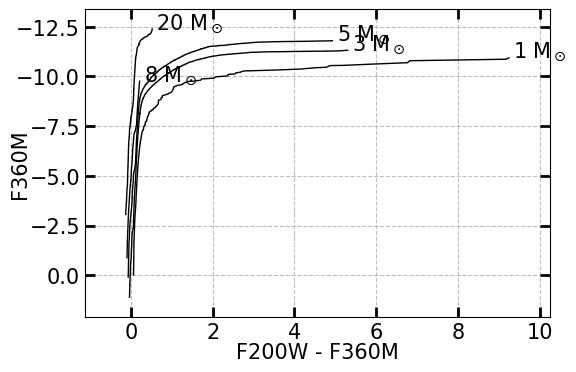

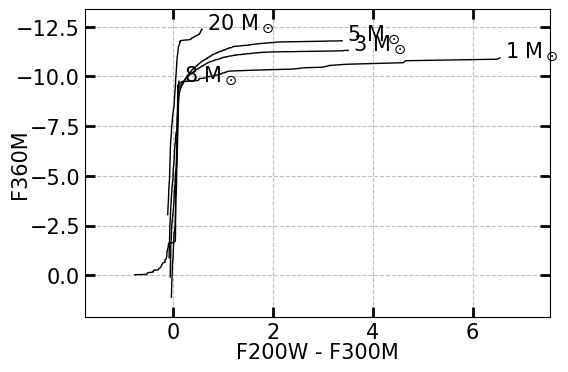

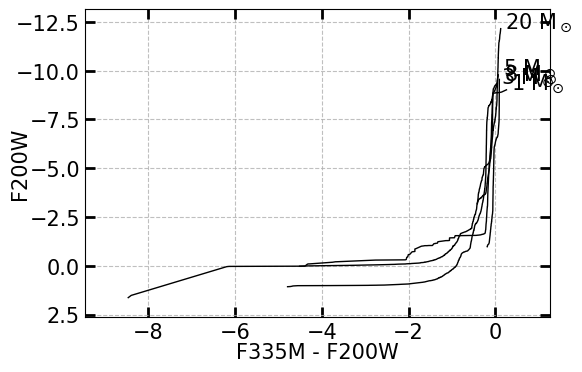

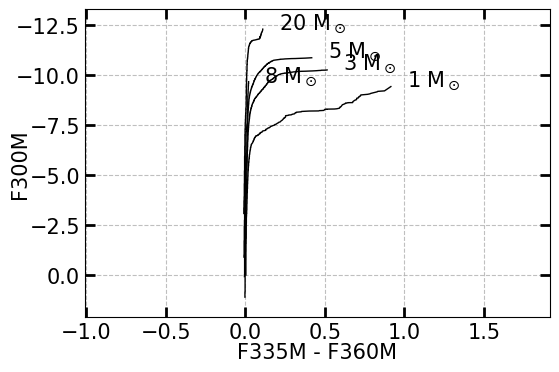

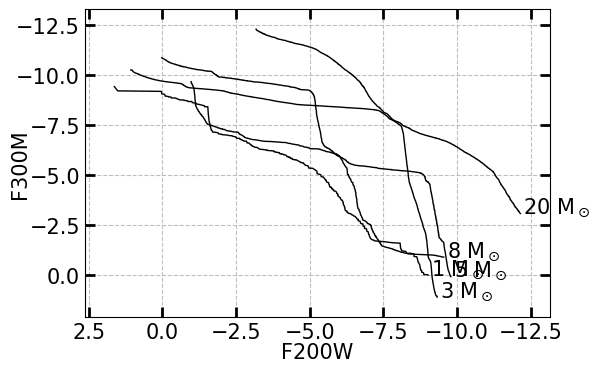

In [220]:
MakeCMD(xmodel=['F200W', 'F335M'],
        ymodel='F360M',
        instrument='NIRCAM')

MakeCMD(xmodel=['F200W', 'F360M'],
        ymodel='F360M',
        instrument='NIRCAM')

MakeCMD(xmodel=['F200W', 'F300M'],
        ymodel='F360M',
        instrument='NIRCAM')

MakeCMD(xmodel=['F335M', 'F200W'],
        ymodel='F200W',
        instrument='NIRCAM')

MakeCMD(xmodel=['F335M', 'F360M'],
        ymodel='F300M',
        instrument='NIRCAM')

MakeCMD(xmodel='F200W',
        ymodel='F300M',
        instrument='NIRCAM')

# Testing on MakeCMD

Now that the JWST CMD models have successfully been integrated into MakeCMD, let's test it out by import MakeCMD

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

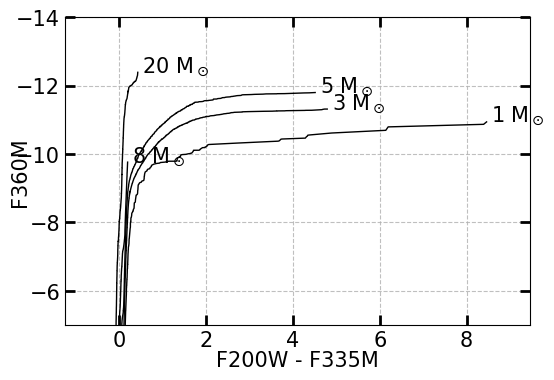

In [4]:
from XRBID.CMDs import MakeCMD

MakeCMD(xmodel=['F200W', 'F335M'],
        ymodel='F360M',
        instrument='nircam',
        ylim=(-5,-14))

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F300M', ylabel='F360M'>)

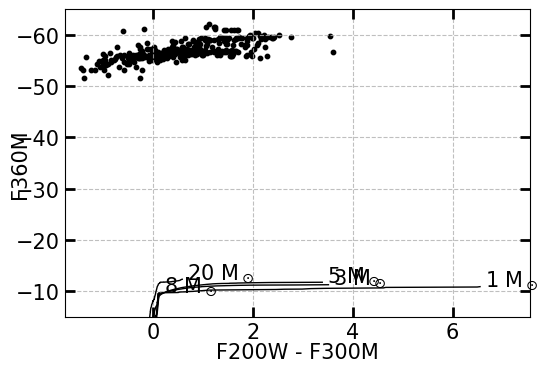

In [ ]:
# this is amazing :'(
MakeCMD(sources=xrbs,
        xcolor=['F200W', 'F300M'],
        ycolor='F360M',
        instrument='nircam',
        ylim=(-5,-65))